# Initial Python Setup

In [2]:
import pandas as pd
import numpy as np
import requests as req
import statsmodels.api as sm

from matplotlib import pyplot as plt

from zipfile import ZipFile
from io import BytesIO
from IPython.display import display

# Setting Variables
Here we are just setting variables (such as the url, file name, etc) to tidy up the importing code

In [3]:
url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
file_name = 'survey_results_public.csv'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Importing the Dataset

In [4]:
response = req.get(url)
zip_file = ZipFile(BytesIO(response.content))
df = pd.read_csv(BytesIO(zip_file.read(file_name)))
display(df)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.0,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trello,Slack;Zoom

,ConvertedCompYearly,Currency,CompTotal,CompFreq
0,NaN,NaN,NaN,NaN
1,NaN,CAD\tCanadian dollar,NaN,NaN
2,40205.0,GBP\tPound sterling,32000.0,Yearly
3,215232.0,ILS\tIsraeli new shekel,60000.0,Monthly
4,NaN,USD\tUnited States dollar,NaN,NaN
...,...,...,...,...
73263,NaN,USD\tUnited States dollar,60000.0,Yearly
73264,NaN,USD\tUnited States dollar,107000.0,Yearly
73265,NaN,USD\tUnited States dollar,NaN,NaN
73266,NaN,GBP\tPound sterling,58500.0,Yearly


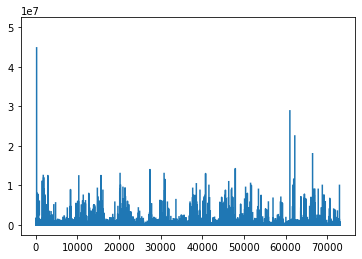

In [5]:
display(df[["ConvertedCompYearly", "Currency", "CompTotal", "CompFreq"]])
plt.plot(df["ConvertedCompYearly"])

US - Conversion Rates
control for state level

deep conversation about endogeneity
significant portion about econometics
harvard math > some other comp sci

pandas can increase number of cols

# Cleaning the Data

In order to use this dataset, we will need to clean it up and interpret some of the variables

## Dummy Variables

Many of the variables in the data are multi-selected lists, where the user can choose none, any, or all of the options. These are stored as a list seperated by a `;` deliminer.

We can use the dataframe method

```python
df.str.get_dummies(';')
```

to split these up into dummy variables

In [6]:
dummy_languages = df["LanguageHaveWorkedWith"].str.get_dummies(';')
dummy_learncodeoffline = df["LearnCode"].str.get_dummies(";").add_prefix("Learn From ")
dummy_learncodeonline = df["LearnCodeOnline"].str.get_dummies(";").add_prefix("Learn From ")

df1 = pd.concat([df,dummy_languages, dummy_learncodeoffline, dummy_learncodeonline], axis = 1)
display(df1)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,APL,Assembly,Bash/Shell,C,C#,C++,COBOL,Clojure,Crystal,Dart,Delphi,Elixir,Erlang,F#,Fortran,Go,Groovy,HTML/CSS,Haskell,Java,JavaScript,Julia,Kotlin,LISP,Lua,MATLAB,OCaml,Objective-C,PHP,Perl,PowerShell,Python,R,Ruby,Rust,SAS,SQL,Scala,Solidity,Swift,TypeScript,VBA,Learn From Books / Physical media,Learn From Coding Bootcamp,Learn From Colleague,Learn From Friend or family member,Learn From Hackathons (virtual or in-person),Learn From On the job training,Learn From Online Courses or Certification,Learn From Other (please specify):,"Learn From Other online resources (e.g., videos, blogs, forum)","Learn From School (i.e., University, College, etc)","Learn From Auditory material (e.g., podcasts)",Learn From Blogs,Learn From Certification videos,Learn From Coding sessions (live or recorded),Learn From How-to videos,Learn From Interactive tutorial,Learn From Online books,"Learn From Online challenges (e.g., daily or weekly coding challenges)",Learn From Online forum,Learn From Other (Please specify):,Learn From Programming Games,Learn From Stack Overflow,Learn From Technical documentation,Learn From Video-based Online Courses,Learn From Written Tutorials,Learn From Written-based Online Courses
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingd

In [16]:
display(df1[list(dummy_learncodeoffline.columns) + list(dummy_learncodeonline.columns)])

,Learn From Books / Physical media,Learn From Coding Bootcamp,Learn From Colleague,Learn From Friend or family member,Learn From Hackathons (virtual or in-person),Learn From On the job training,Learn From Online Courses or Certification,Learn From Other (please specify):,"Learn From Other online resources (e.g., videos, blogs, forum)","Learn From School (i.e., University, College, etc)","Learn From Auditory material (e.g., podcasts)",Learn From Blogs,Learn From Certification videos,Learn From Coding sessions (live or recorded),Learn From How-to videos,Learn From Interactive tutorial,Learn From Online books,"Learn From Online challenges (e.g., daily or weekly coding challenges)",Learn From Online forum,Learn From Other (Please specify):,Learn From Programming Games,Learn From Stack Overflow,Learn From Technical documentation,Learn From Video-based Online Courses,Learn From Written Tutorials,Learn From Written-based Online Courses
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73263,1,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,1,0
73264,0,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,1,1,1,0
73265,1,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,1,0,0,0,1,1,1,1,0,1
73266,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


By keeping the dummy dataframe variables, we can easily grab all of the columns using the following method

```python
dummy_learncodeoffline.columns
```

This will make it significantly easier in order to grab variables we want when regressing

statsmodels

linear models projectx